In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
import warnings
import imblearn

from collections import Counter

from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler
from imblearn.pipeline import make_pipeline

from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras import layers
from tensorflow.keras import losses

from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau

import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences




import pydot

In [2]:
train_data= pd.read_csv('data_train.csv')
train_data.dropna(axis = 0, how ='any',inplace=True) 


train_data['Num_words_text'] = train_data['review'].apply(lambda x:len(str(x).split())) 
mask = train_data['Num_words_text'] >2
train_data = train_data[mask]

print('-------Train data--------')
print(train_data['sentiment'].value_counts())
print(len(train_data))
max_train_sentence_length  = train_data['Num_words_text'].max()

test_data= pd.read_csv('data_test.csv')
test_data.dropna(axis = 0, how ='any',inplace=True) 
test_data['Num_words_text'] = test_data['review'].apply(lambda x:len(str(x).split())) 

max_test_sentence_length  = test_data['Num_words_text'].max()

mask = test_data['Num_words_text'] >2
test_data = test_data[mask]

print('-------Test data--------')
print(test_data['sentiment'].value_counts())
print(len(test_data))
print('-------------------------')

print('Train Max Sentence Length :'+str(max_train_sentence_length))
print('Test Max Sentence Length :'+str(max_test_sentence_length))

#all_sentences = train_data['text'].tolist() + test_data['text'].tolist()

-------Train data--------
1    7743
0     755
Name: sentiment, dtype: int64
8498
-------Test data--------
1    1905
0     222
Name: sentiment, dtype: int64
2127
-------------------------
Train Max Sentence Length :1206
Test Max Sentence Length :383


In [3]:
num_words = 20000

tokenizer = Tokenizer(num_words=num_words,oov_token="unk")
tokenizer.fit_on_texts(train_data['review'].tolist())

# print(str(tokenizer.texts_to_sequences(['nice spot hang friend see also sunset amazing beside many option restaurant choose along'])))

In [4]:
corpus = train_data['review'].values.astype('U')
# test_data['review'].values.astype('U')

In [5]:
vec = TfidfVectorizer(stop_words='english')
resp = vec.fit_transform(corpus)
print(resp)
# print(train_data['review'])

  (0, 5077)	0.10530775416882965
  (0, 5809)	0.2298200452072474
  (0, 9533)	0.09830734044150571
  (0, 3465)	0.27385138724695707
  (0, 1414)	0.25355974490427574
  (0, 7561)	0.27385138724695707
  (0, 5253)	0.23326810256159441
  (0, 6677)	0.2298200452072474
  (0, 12902)	0.25355974490427574
  (0, 7649)	0.25355974490427574
  (0, 8249)	0.2619815373984429
  (0, 2424)	0.24168989505576158
  (0, 2770)	0.5239630747968858
  (0, 925)	0.25355974490427574
  (0, 1993)	0.10223723929298528
  (1, 12188)	0.14162804575532145
  (1, 8660)	0.24176857770655466
  (1, 9664)	0.15930429629025908
  (1, 11149)	0.18954103060944102
  (1, 6007)	0.2237623997079001
  (1, 9083)	0.2442718403710865
  (1, 1352)	0.20298986674853403
  (1, 9180)	0.2719798368310526
  (1, 3705)	0.20375935152997388
  (1, 11620)	0.13835128529491011
  :	:
  (8496, 7249)	0.1380894442246654
  (8496, 5533)	0.1191815093346397
  (8496, 13257)	0.1377456435552392
  (8496, 12188)	0.14171453753187202
  (8497, 2509)	0.42977063871457044
  (8497, 2746)	0.3606697

In [8]:
X_train, X_valid, y_train, y_valid = train_test_split(corpus,\
                                                      train_data['sentiment'].tolist(),\
                                                      test_size=0.2,\
                                                      stratify = train_data['sentiment'].tolist(),\
                                                      random_state=0)

print('Train data len:'+str(len(X_train)))
print('Class distribution'+str(Counter(y_train)))
print('Valid data len:'+str(len(X_valid)))
print('Class distribution'+ str(Counter(y_valid)))

# sm = SMOTE()
# x_train_res, y_train_res = sm.fit_resample(X_train, y_train)


x_train = np.array( tokenizer.texts_to_sequences(X_train) )
x_valid = np.array( tokenizer.texts_to_sequences(X_valid) )
x_test  = np.array( tokenizer.texts_to_sequences(test_data['review'].tolist()) )

#Normal
# x_train = pad_sequences(x_train, padding='post', maxlen=1210)
# x_valid = pad_sequences(x_valid, padding='post', maxlen=1210)
# x_test = pad_sequences(x_test, padding='post', maxlen=390)

#Undersampling
x_train = pad_sequences(x_train, padding='post', maxlen=1210)
x_valid = pad_sequences(x_valid, padding='post', maxlen=1210)
x_test = pad_sequences(x_test, padding='post', maxlen=390)

print(x_train[0])

le = LabelEncoder()

train_labels = le.fit_transform(y_train)
train_labels = np.asarray( tf.keras.utils.to_categorical(train_labels))
#print(train_labels)
valid_labels = le.transform(y_valid)
valid_labels = np.asarray( tf.keras.utils.to_categorical(valid_labels))

test_labels = le.transform(test_data['sentiment'].tolist())
test_labels = np.asarray(tf.keras.utils.to_categorical(test_labels))
list(le.classes_)


train_ds = tf.data.Dataset.from_tensor_slices((x_train,train_labels))
valid_ds = tf.data.Dataset.from_tensor_slices((x_valid,valid_labels))
test_ds = tf.data.Dataset.from_tensor_slices((x_test,test_labels))

Train data len:6798
Class distributionCounter({1: 6194, 0: 604})
Valid data len:1700
Class distributionCounter({1: 1549, 0: 151})


E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  app.launch_new_instance()
E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


[36 68 96 ...  0  0  0]


In [9]:
print(y_train[:10])
train_labels = le.fit_transform(y_train)
print('Text to number')
print(train_labels[:10])
train_labels = np.asarray( tf.keras.utils.to_categorical(train_labels))
print('Number to category')
print(train_labels[:10])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Text to number
[1 1 1 1 1 1 1 1 1 1]
Number to category
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [10]:
# count =0
# print('======Train dataset ====')
# for value,label in train_ds:
#     count += 1
#     print(value,label)
#     if count==2:
#         break
# count =0
# print('======Validation dataset ====')
# for value,label in valid_ds:
#     count += 1
#     print(value,label)
#     if count==2:
#         break
# print('======Test dataset ====')
# for value,label in test_ds:
#     count += 1
#     print(value,label)
#     if count==2:
#         break

In [11]:
max_features =20000
embedding_dim =64
sequence_length = 1210

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(max_features +1, embedding_dim, input_length=sequence_length,\
                                    embeddings_regularizer = regularizers.l2(0.0005)))                                    

model.add(tf.keras.layers.Conv1D(128,2, padding='valid', activation='relu',\
                                 kernel_regularizer = regularizers.l2(0.0005),\
                                 bias_regularizer = regularizers.l2(0.0005)))                               


model.add(tf.keras.layers.GlobalMaxPooling1D())

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Dense(32, activation='relu',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001)))

model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Dense(32, activation='relu',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001)))

model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Dense(2, activation='sigmoid',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001)))

# custom_early_stopping = EarlyStopping(
#     monitor='val_loss', 
#     patience=1, 
#     min_delta=0.001, 
#     mode='auto'
# )



model.summary()
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), optimizer='adam', metrics=["CategoricalAccuracy"])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1210, 64)          1280064   
_________________________________________________________________
conv1d (Conv1D)              (None, 1209, 128)         16512     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
flatten (Flatten)            (None, 128)               0         
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                4128      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0

In [12]:
import graphviz

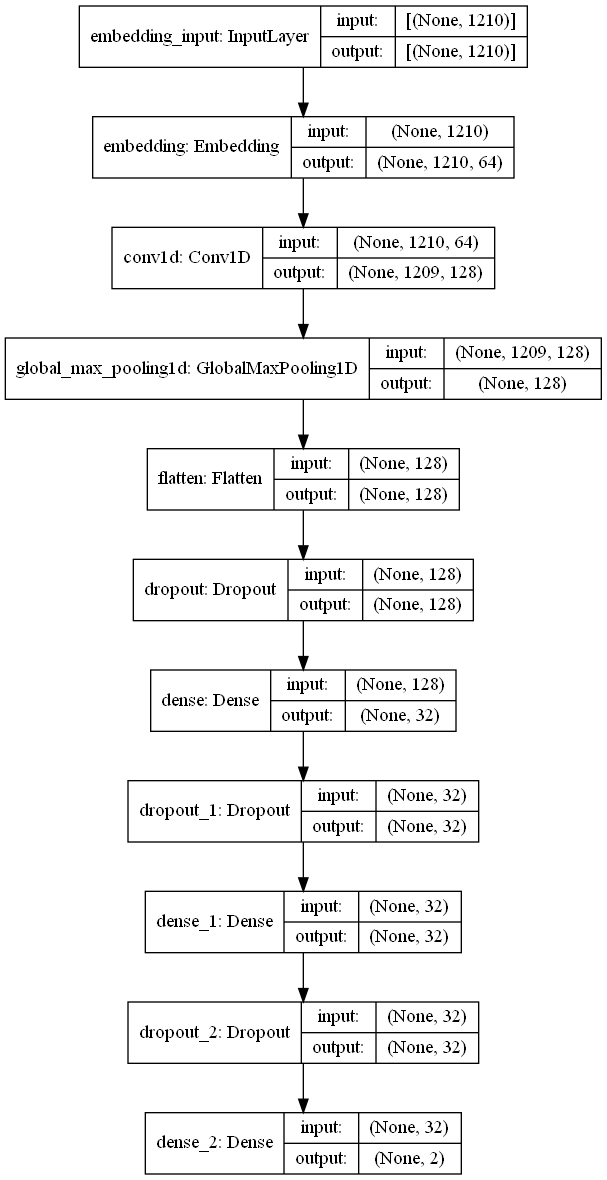

In [13]:
tf.keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

In [14]:
epochs = 5

# Fit the model using the train and test datasets.
#history = model.fit(x_train, train_labels,validation_data= (x_test,test_labels),epochs=epochs )
history = model.fit(train_ds.shuffle(2000).batch(64),
                    epochs= epochs ,
                    validation_data=valid_ds.batch(64),
                    verbose=1)

# ,
#                     callbacks=[custom_early_stopping]

Epoch 1/5


E:\Anaconda3\lib\site-packages\tensorflow\python\keras\backend.py:4870: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`categorical_crossentropy` received `from_logits=True`, but '


107/107 [==============================] - 40s 271ms/step - loss: 0.5456 - categorical_accuracy: 0.9084 - val_loss: 0.3741 - val_categorical_accuracy: 0.9112
Epoch 2/5
107/107 [==============================] - 24s 227ms/step - loss: 0.3332 - categorical_accuracy: 0.9112 - val_loss: 0.2918 - val_categorical_accuracy: 0.9112
Epoch 3/5
107/107 [==============================] - 25s 234ms/step - loss: 0.2652 - categorical_accuracy: 0.9117 - val_loss: 0.2593 - val_categorical_accuracy: 0.9112
Epoch 4/5
107/107 [==============================] - 24s 224ms/step - loss: 0.2277 - categorical_accuracy: 0.9309 - val_loss: 0.2515 - val_categorical_accuracy: 0.9271
Epoch 5/5
107/107 [==============================] - 24s 223ms/step - loss: 0.2024 - categorical_accuracy: 0.9497 - val_loss: 0.2692 - val_categorical_accuracy: 0.9265


In [15]:
len(history.history['loss'])

5

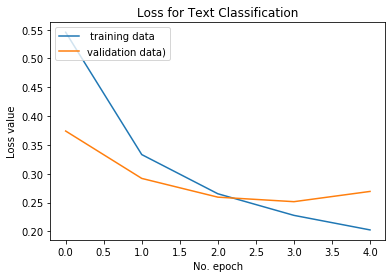

In [16]:
plt.plot(history.history['loss'], label=' training data')
plt.plot(history.history['val_loss'], label='validation data)')
plt.title('Loss for Text Classification')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

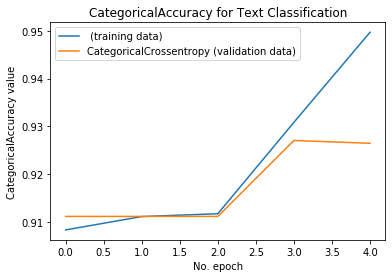

In [17]:
plt.plot(history.history['categorical_accuracy'], label=' (training data)')
plt.plot(history.history['val_categorical_accuracy'], label='CategoricalCrossentropy (validation data)')
plt.title('CategoricalAccuracy for Text Classification')
plt.ylabel('CategoricalAccuracy value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [ ]:
model.save('WeightedModel3\\tf_cnnmodel') 
json_string = tokenizer.to_json()

In [ ]:
import json
# with open('tf_cnnmodel', 'w') as outfile:
#     json.dump(json_string, outfile)

In [18]:
new_model = tf.keras.models.load_model('WeightedModel2\\tf_cnnmodel')
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 390, 64)           1280064   
_________________________________________________________________
conv1d (Conv1D)              (None, 389, 128)          16512     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
flatten (Flatten)            (None, 128)               0         
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                4128      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0

In [19]:
test_data = pd.read_csv('data_test.csv', converters={'reviews' : str})
# test_data.drop(["Date", "Content"], axis=1, inplace=True)
# test_data.fillna(0)
# test_data = test_data.fillna("")
test_data.sample(5)

,Date,Content,review,scores,compound,sentiment
1883,18-Jun,Seminyak beach is littered with trash. We went...,seminyak litter trash go comb walk hop beautif...,"{'neg': 0.148, 'neu': 0.633, 'pos': 0.219, 'co...",0.5719,1
1175,16-Oct,I went in the morning. The beach is clean and ...,go morning clean quietthere well build park be...,"{'neg': 0.0, 'neu': 0.652, 'pos': 0.348, 'comp...",0.5859,1
1772,13-Dec,Used to stay at kuta area for 3-4times. It was...,use stay kuta area 34times ist time stay near ...,"{'neg': 0.115, 'neu': 0.754, 'pos': 0.131, 'co...",0.1027,1
1041,17-May,"Nice beach, the sand very soft and niceGreat s...",nice sand soft nicegreat scenery sad sit place...,"{'neg': 0.278, 'neu': 0.585, 'pos': 0.137, 'co...",-0.4404,0
898,17-Apr,The Yogi:After a nice scooter ride from Uluwat...,yogiafter nice scooter ride uluwatu nu dua fin...,"{'neg': 0.136, 'neu': 0.568, 'pos': 0.296, 'co...",0.9000,1


In [20]:
try:
    x_test  = np.array( tokenizer.texts_to_sequences(test_data['review'].tolist()) )
    # x_test = tokenizer
    x_test = pad_sequences(x_test, padding='post', maxlen=1210)
except AttributeError:
    pass

E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [21]:
# Generate predictions (probabilities -- the output of the last layer)
# on test  data using `predict`
print("Generate predictions for all samples")
predictions = new_model.predict(x_test)
print(predictions)
predict_results = predictions.argmax(axis=1)

Generate predictions for all samples
[[0.09216475 0.8810382 ]
 [0.05293751 0.928354  ]
 [0.06831741 0.90956306]
 ...
 [0.10228038 0.87140906]
 [0.6566642  0.34539357]
 [0.20985025 0.7640997 ]]


In [22]:
test_data['pred_sentiment'] = predict_results
test_data['pred_sentiment'] = np.where((test_data.pred_sentiment == 0),'0',test_data.pred_sentiment)
test_data['pred_sentiment'] = np.where((test_data.pred_sentiment == '1'),'1',test_data.pred_sentiment)

In [23]:
labels = ['0', '1']
    
print(classification_report(test_data['sentiment'].values.astype(int).astype(str),test_data['pred_sentiment'].values,labels=labels))

              precision    recall  f1-score   support

           0       0.54      0.56      0.55       222
           1       0.95      0.94      0.95      1905

    accuracy                           0.90      2127
   macro avg       0.74      0.75      0.75      2127
weighted avg       0.91      0.90      0.90      2127



In [24]:
# sentiment = ['negative','positive']
sequence20 = tokenizer.texts_to_sequences(['perfect morning walk amazing sunrise'])


test20 = pad_sequences(sequence20, padding="post")
labels[np.around(new_model.predict(test20)).argmax(axis=1)[0]]

'1'

In [32]:
sequence30 = tokenizer.texts_to_sequences([''])


test30 = pad_sequences(sequence30, padding="post")
labels[np.around(new_model.predict(test30)).argmax(axis=1)[0]]

'0'

In [26]:
# df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])

confusion_matrix = pd.crosstab(test_data['sentiment'], test_data['pred_sentiment'], rownames=['Actual'], colnames=['Predicted'])
print (confusion_matrix)

Predicted    0     1
Actual              
0          124    98
1          107  1798


In [27]:
roc_auc = roc_auc_score(test_data['sentiment'], test_data['pred_sentiment'])

print("ROC AUC Score")
print(roc_auc)

ROC AUC Score
0.751195289777967
